In [46]:
import os
import pickle
import numpy as np
import scipy.sparse as sp

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
data_16_folder = "data//clean_data//data_16//"

In [17]:
data = pickle.load(open("data//data_x//data_processed.pkl", "rb"))
label = pickle.load(open("data//data_x//label.pkl", "rb"))
print(set(label))
print(len(set(label)))

{'giao-duc-khuyen-hoc', 'tai-chinh-kinh-doanh', 'chinh-tri', 'du-lich', 'thoi-su-chinh-tri', 'ban-doc', 'thoi-su', 'suc-khoe', 'gioi-tre', 'giai-tri', 'bat-dong-san', 'the-gioi', 'su-kien', 'doi-song', 'giao-duc', 'khoa-hoc-cong-nghe', 'suc-manh-so', 'tuan-viet-nam', 'van-hoa', 'kinh-te', 'cong-doan', 'xe', 'tam-su', 'o-to-xe-may', 'khoa-hoc', 'cuoi', 'quan-su-quoc-phong', 'van-hoa-giai-tri', 'nhip-song-tre', 'kinh-doanh', 'tinh-yeu-gioi-tinh', 'talkshow', 'the-thao', 'xa-hoi', 'cong-nghe', 'phap-luat', 'tam-long-nhan-ai', 'y-kien'}
38


In [14]:
group = [["chinh-tri"], ["cong-nghe"], ["khoa-hoc"], ["doi-song"], ["du-lich"], ["giai-tri"], ["van-hoa"], ["giao-duc"], 
         ["kinh-doanh"], ["o-to-xe-may"], ["phap-luat"], ["quan-su-quoc-phong"], ["suc-khoe"], ["the-gioi"], ["the-thao"], 
         ["xa-hoi"]]

In [20]:
def createCleanData(data, labels):  
    data_16 = []
    label_16 = []
    for i in group:
        topic = i[0]
        for la in i:
            # samples are store in order so just need to find start index and end index
            start_index = labels.index(la)
            end_index = labels.count(la) + start_index
            sub_data = data[start_index:end_index]
            # take random 3000 samples
            sub_data = random.sample(sub_data, 3000)
            len_sub_data = len(sub_data)
            # verbose
            print("topic: ", la)
            print("start index : ", start_index, "end index :", end_index, "len samples :", len_sub_data)
            data_16 += sub_data
            label_16 += len_sub_data*[topic]
    # verbose
    print(len(data_16))
    print(len(label_16))
    pickle.dump(data_16, open("data//clean_data//data_16.pkl", "wb"))
    pickle.dump(label_16, open("data//clean_data//label_16.pkl", "wb"))

In [21]:
createCleanData(data, label)

topic:  chinh-tri
start index :  12623 end index : 48244 len samples : 3000
topic:  cong-nghe
start index :  52777 end index : 58191 len samples : 3000
topic:  khoa-hoc
start index :  313870 end index : 360063 len samples : 3000
topic:  doi-song
start index :  77507 end index : 117122 len samples : 3000
topic:  du-lich
start index :  117122 end index : 148790 len samples : 3000
topic:  giai-tri
start index :  148790 end index : 255068 len samples : 3000
topic:  van-hoa
start index :  996303 end index : 1005870 len samples : 3000
topic:  giao-duc
start index :  256068 end index : 305340 len samples : 3000
topic:  kinh-doanh
start index :  360063 end index : 399966 len samples : 3000
topic:  o-to-xe-may
start index :  414679 end index : 462017 len samples : 3000
topic:  phap-luat
start index :  462017 end index : 548757 len samples : 3000
topic:  quan-su-quoc-phong
start index :  548757 end index : 561422 len samples : 3000
topic:  suc-khoe
start index :  562422 end index : 598275 len sa

## Data Exploration

#### Compare ngram tfidf (n = 1, 2, 3, 4)

In [24]:
data_16 = pickle.load(open(data_16_folder + "data_16.pkl", "rb"))
label_16 = pickle.load(open(data_16_folder + "label_16.pkl", "rb"))

In [30]:
def createAndSaveTfidfdata(data, ngram_range, max_features):
    tfidf_vect = TfidfVectorizer(lowercase=False, analyzer='word', ngram_range=ngram_range, max_features=max_features)
    tfidf_data = tfidf_vect.fit_transform(data)
    # Save sparse matrix
    sp.save_npz(data_16_folder + "tfidf_data_{}_{}.npz".format(ngram_range, max_features), tfidf_data)
    # Save vectorizer for later build pipeline
    pickle.dump(tfidf_vect, open(data_16_folder + "vectorizer//tfidf_{}_{}".format(ngram_range, max_features), "wb"))
    print("Done: {}{}".format(ngram_range, max_features))

In [ ]:
list_n_gram = [(1,1), (2,2), (3,3), (4,4), (1,5)]
for i in list_n_gram:
    createAndSaveTfidfdata(data=data_16, ngram_range=i, max_features=30000)

Done: (1, 1)30000
Done: (2, 2)30000
Done: (3, 3)30000
Done: (4, 4)30000


In [47]:
# evaluate by 2 models: LinearSVC and LogisticRegression
def trainModel(classifier, data, labels, train_data, train_labels, test_data, test_labels, stats_name, model_name):
    # split to training and validation data
    X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, random_state=21)
    
    # train the model
    classifier.fit(X_train, y_train)
    
    # build the stats report
        # on the training data
    train_pred = classifier.predict(train_data)
    train_clf_rp = metrics.classification_report(train_labels, train_pred)
    train_cfs_rp = metrics.confusion_matrix(train_labels, train_pred, labels=classifier.classes_)
        # on the testing data
    test_pred = classifier.predict(test_data)
    test_clf_rp = metrics.classification_report(test_labels, test_pred)
    test_cfs_rp = metrics.confusion_matrix(test_labels, test_pred, labels=classifier.classes_)
        # on the whole data
    pred = classifier.predict(data)
    clf_rp = metrics.classification_report(labels, pred)
    cfs_rp = metrics.confusion_matrix(labels, pred, labels=classifier.classes_)
        # save the report 
    with open(data_16_folder + 'report//%s.txt' %stats_name, 'w', encoding='utf-8') as report_file:
        report_file.write('Training data:\n')
        report_file.write(train_clf_rp)
        report_file.write(np.array2string(train_cfs_rp, separator = ','))
        report_file.write('\n\n')
        
        report_file.write('\n\nTesting data:\n')
        report_file.write(test_clf_rp)
        report_file.write(np.array2string(test_cfs_rp, separator = ','))
        report_file.write('\n\n')
        
        report_file.write('\n\nWhole data:\n')
        report_file.write(clf_rp)
        report_file.write(np.array2string(cfs_rp, separator = ','))
        
        report_file.close()
    # save the model 
    # dump(classifier, 'models//%s.joblib' %model_name)
    # print the accuracy (for choosing model)
    print('Testing data accuracy: ', metrics.accuracy_score(test_pred, test_labels))

In [49]:
models = [LinearSVC(), LogisticRegression()]
model_names = ["LinearSVC", "LogisticRegression"]

In [50]:
data_16_11 = sp.load_npz(data_16_folder + "tfidf_data_(1, 1)_30000.npz")
label_16_11 = pickle.load(open(data_16_folder + "label_16.pkl", "rb"))

for ind, md in enumerate(models):
    train_data, test_data, train_labels, test_labels = train_test_split(data_16_11, label_16_11, 
                                                                        test_size=0.2, random_state=21)
    print("Training length: ", train_data.shape[0])
    print("Testing length: ", test_data.shape[0])
    trainModel(classifier=md, data=data_16_11, labels = label_16_11, 
               train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, 
               stats_name="tfidf_11_{}".format(model_names[ind]), model_name=model_names[ind])

Training length:  38400
Testing length:  9600
Testing data accuracy:  0.8109375
Training length:  38400
Testing length:  9600


c:\users\hhd\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\hhd\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing data accuracy:  0.8015625


In [51]:
data_16_11 = sp.load_npz(data_16_folder + "tfidf_data_(2, 2)_30000.npz")
label_16_11 = pickle.load(open(data_16_folder + "label_16.pkl", "rb"))

for ind, md in enumerate(models):
    train_data, test_data, train_labels, test_labels = train_test_split(data_16_11, label_16_11, 
                                                                        test_size=0.2, random_state=21)
    print("Training length: ", train_data.shape[0])
    print("Testing length: ", test_data.shape[0])
    trainModel(classifier=md, data=data_16_11, labels = label_16_11, 
               train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, 
               stats_name="tfidf_22_{}".format(model_names[ind]), model_name=model_names[ind])

Training length:  38400
Testing length:  9600
Testing data accuracy:  0.8176041666666667
Training length:  38400
Testing length:  9600
Testing data accuracy:  0.8054166666666667


In [52]:
data_16_11 = sp.load_npz(data_16_folder + "tfidf_data_(3, 3)_30000.npz")
label_16_11 = pickle.load(open(data_16_folder + "label_16.pkl", "rb"))

for ind, md in enumerate(models):
    train_data, test_data, train_labels, test_labels = train_test_split(data_16_11, label_16_11, 
                                                                        test_size=0.2, random_state=21)
    print("Training length: ", train_data.shape[0])
    print("Testing length: ", test_data.shape[0])
    trainModel(classifier=md, data=data_16_11, labels = label_16_11, 
               train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, 
               stats_name="tfidf_33_{}".format(model_names[ind]), model_name=model_names[ind])

Training length:  38400
Testing length:  9600
Testing data accuracy:  0.7547916666666666
Training length:  38400
Testing length:  9600
Testing data accuracy:  0.7517708333333334


In [53]:
data_16_11 = sp.load_npz(data_16_folder + "tfidf_data_(4, 4)_30000.npz")
label_16_11 = pickle.load(open(data_16_folder + "label_16.pkl", "rb"))

for ind, md in enumerate(models):
    train_data, test_data, train_labels, test_labels = train_test_split(data_16_11, label_16_11, 
                                                                        test_size=0.2, random_state=21)
    print("Training length: ", train_data.shape[0])
    print("Testing length: ", test_data.shape[0])
    trainModel(classifier=md, data=data_16_11, labels = label_16_11, 
               train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, 
               stats_name="tfidf_44_{}".format(model_names[ind]), model_name=model_names[ind])

Training length:  38400
Testing length:  9600
Testing data accuracy:  0.6684375
Training length:  38400
Testing length:  9600
Testing data accuracy:  0.6829166666666666


In [54]:
data_16_11 = sp.load_npz(data_16_folder + "tfidf_data_(1, 5)_30000.npz")
label_16_11 = pickle.load(open(data_16_folder + "label_16.pkl", "rb"))

for ind, md in enumerate(models):
    train_data, test_data, train_labels, test_labels = train_test_split(data_16_11, label_16_11, 
                                                                        test_size=0.2, random_state=21)
    print("Training length: ", train_data.shape[0])
    print("Testing length: ", test_data.shape[0])
    trainModel(classifier=md, data=data_16_11, labels = label_16_11, 
               train_data=train_data, train_labels=train_labels, test_data=test_data, test_labels=test_labels, 
               stats_name="tfidf_15_{}".format(model_names[ind]), model_name=model_names[ind])

Training length:  38400
Testing length:  9600
Testing data accuracy:  0.8326041666666667
Training length:  38400
Testing length:  9600
Testing data accuracy:  0.8113541666666667


    Conclusion: n = 1, 2 have more information than 3, 4

#### Visualize using tSNE plot

In [59]:
def visualizeTsne(data, label, n_components, perplexity):
    # Apply truncated before using tSNE
    svd = TruncatedSVD(n_components, n_iter=7, random_state=42)
    data_svd = svd.fit_transform(data)
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=300)
    tsne_results = tsne.fit_transform(data_svd)
    # Plot tSNE
        # Mapping the color to label
    unique_label = list(set(label)) # convert to list 
    
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(frameon=False)
    plt.setp(ax, xticks=(), yticks=())
    plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    for la in unique_label:
        indices = [i for i, x in enumerate(label) if x == la]
        plt.scatter(tsne_results[:, 0][indices], tsne_results[:, 1][indices], label=la)
    plt.legend()
    plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 48000 samples in 0.203s...
[t-SNE] Computed neighbors for 48000 samples in 325.920s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48000
[t-SNE] Computed conditional probabilities for sample 2000 / 48000
[t-SNE] Computed conditional probabilities for sample 3000 / 48000
[t-SNE] Computed conditional probabilities for sample 4000 / 48000
[t-SNE] Computed conditional probabilities for sample 5000 / 48000
[t-SNE] Computed conditional probabilities for sample 6000 / 48000
[t-SNE] Computed conditional probabilities for sample 7000 / 48000
[t-SNE] Computed conditional probabilities for sample 8000 / 48000
[t-SNE] Computed conditional probabilities for sample 9000 / 48000
[t-SNE] Computed conditional probabilities for sample 10000 / 48000
[t-SNE] Computed conditional probabilities for sample 11000 / 48000
[t-SNE] Computed conditional probabilities for sample 12000 / 48000
[t-SNE] Computed conditional probabilities for 

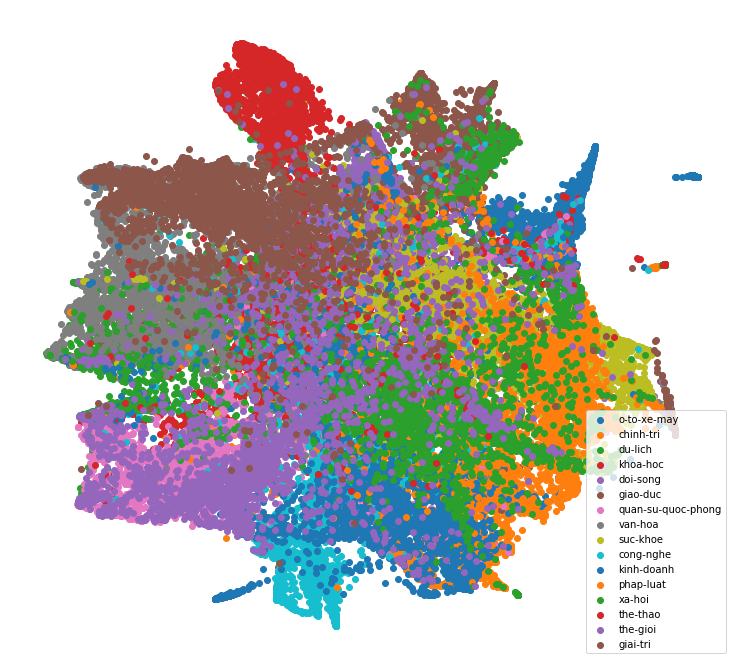

In [60]:
data_16_11 = sp.load_npz(data_16_folder + "tfidf_data_(1, 5)_30000.npz")
label_16_11 = pickle.load(open(data_16_folder + "label_16.pkl", "rb"))
visualizeTsne(data=data_16_11, label=label_16_11, n_components=50, perplexity=40)

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 48000 samples in 0.210s...
[t-SNE] Computed neighbors for 48000 samples in 365.292s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48000
[t-SNE] Computed conditional probabilities for sample 2000 / 48000
[t-SNE] Computed conditional probabilities for sample 3000 / 48000
[t-SNE] Computed conditional probabilities for sample 4000 / 48000
[t-SNE] Computed conditional probabilities for sample 5000 / 48000
[t-SNE] Computed conditional probabilities for sample 6000 / 48000
[t-SNE] Computed conditional probabilities for sample 7000 / 48000
[t-SNE] Computed conditional probabilities for sample 8000 / 48000
[t-SNE] Computed conditional probabilities for sample 9000 / 48000
[t-SNE] Computed conditional probabilities for sample 10000 / 48000
[t-SNE] Computed conditional probabilities for sample 11000 / 48000
[t-SNE] Computed conditional probabilities for sample 12000 / 48000
[t-SNE] Computed conditional probabilities for 

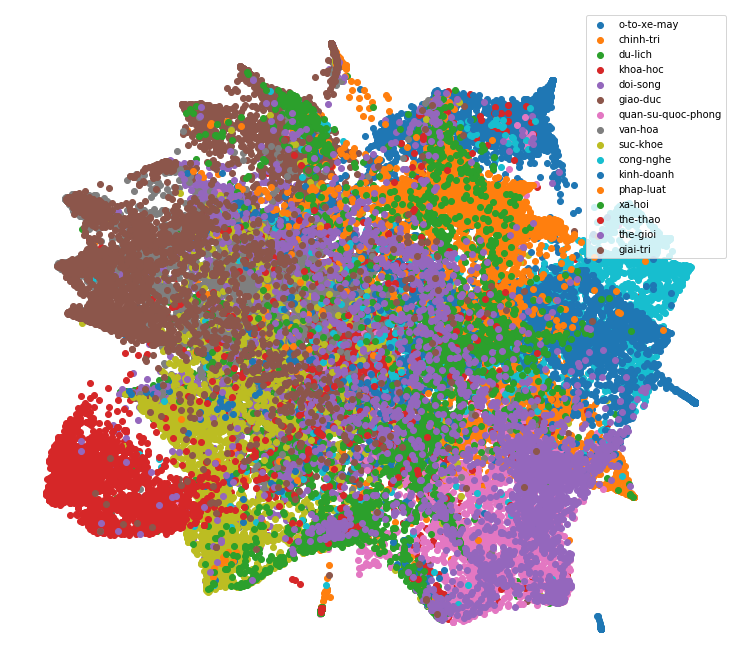

In [61]:
visualizeTsne(data=data_16_11, label=label_16_11, n_components=50, perplexity=100)

In [56]:
def visualizeTsneFollowLabels(data, label, labels_choosed):
    # Find indices
    indices = []
    sub_label = []
    for ind, la in enumerate(labels_choosed):
        inds = [i for i, x in enumerate(label) if x == la]
        indices.append(inds)
        sub_label += len(inds)*[la]
    # print(indices) 
    sub_data = data[indices[0]]
    for la in range(1, len(labels_choosed)):
        sub_data = sp.vstack((sub_data, data[indices[la]]) , format='csr')
    # 
    # print(sub_data.shape[0])
    # print(len(sub_label))
    visualizeTsne(sub_data, sub_label, 20)

## Build Solution

## Opimization

#### Feature Extraction

#### Feature Selection 